In [6]:
%load_ext autoreload
%autoreload 2

### Triplet Loss

We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.


<img src="./images/triplet.png" height="422" width="722" >

Triplet loss is given by the following :-

$$ \mathcal{L}(I_{1}, I_{2}, I_{3}) = ReLU\{m + (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{2}})^{2} - (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{3}})^{2} \}$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [7]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [8]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import TripletCD

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, TripletNet
from losses import ContrastiveLoss, TripletLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [9]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [10]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    
    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker='+', alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)
                
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [11]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [19]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 1.000037
Train: [12800/50000 (26%)]	Loss: 1.005711
Train: [25600/50000 (51%)]	Loss: 0.780242
Train: [38400/50000 (77%)]	Loss: 0.459193
Epoch: 1/20. Train set: Average loss: 0.6622
Epoch: 1/20. Validation set: Average loss: 0.3650
Train: [0/50000 (0%)]	Loss: 0.342551
Train: [12800/50000 (26%)]	Loss: 0.342277
Train: [25600/50000 (51%)]	Loss: 0.302207
Train: [38400/50000 (77%)]	Loss: 0.267344
Epoch: 2/20. Train set: Average loss: 0.2946
Epoch: 2/20. Validation set: Average loss: 0.2795
Train: [0/50000 (0%)]	Loss: 0.238965
Train: [12800/50000 (26%)]	Loss: 0.237900
Train: [25600/50000 (51%)]	Loss: 0.225243
Train: [38400/50000 (77%)]	Loss: 0.218273
Epoch: 3/20. Train set: Average loss: 0.2209
Epoch: 3/20. Validation set: Average loss: 0.2262
Train: [0/50000 (0%)]	Loss: 0.296020
Train: [12800/50000 (26%)]	Loss: 0.176539
Train: [25600/50000 (51%)]	Loss: 0.194615
Train: [38400/50000 (77%)]	Loss: 0.172991
Epoch: 4/20. Train set: Average loss: 0.1812
Epoch: 4/20. Valid

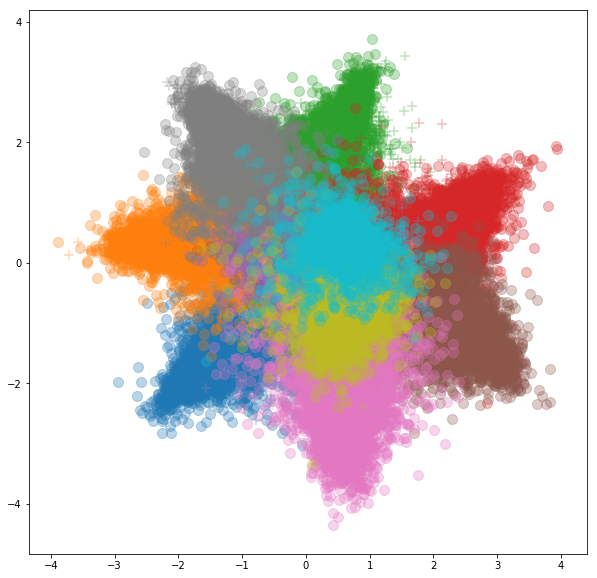

In [20]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model)
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model)


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

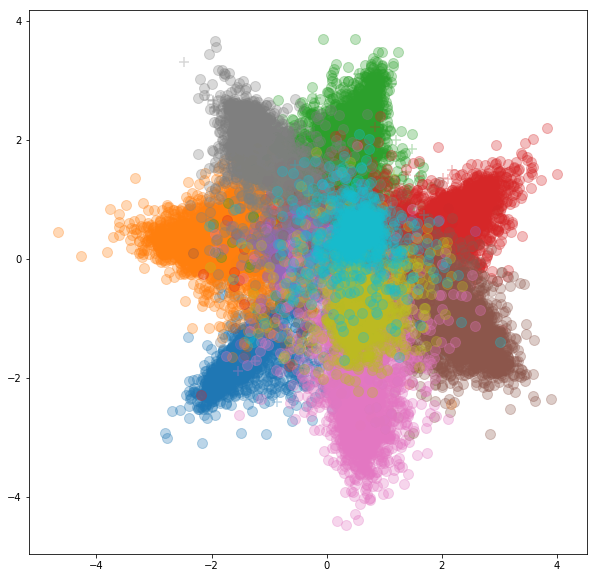

In [21]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model)
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model)


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [5]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)


triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [6]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [7]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 0.999998
Train: [12800/50000 (26%)]	Loss: 0.327251
Train: [25600/50000 (51%)]	Loss: 0.153293
Train: [38400/50000 (77%)]	Loss: 0.125522
Epoch: 1/20. Train set: Average loss: 0.1792
Epoch: 1/20. Validation set: Average loss: 0.0893
Train: [0/50000 (0%)]	Loss: 0.071144
Train: [12800/50000 (26%)]	Loss: 0.072523
Train: [25600/50000 (51%)]	Loss: 0.068827
Train: [38400/50000 (77%)]	Loss: 0.056566
Epoch: 2/20. Train set: Average loss: 0.0640
Epoch: 2/20. Validation set: Average loss: 0.0575
Train: [0/50000 (0%)]	Loss: 0.040103
Train: [12800/50000 (26%)]	Loss: 0.042230
Train: [25600/50000 (51%)]	Loss: 0.047877
Train: [38400/50000 (77%)]	Loss: 0.043372
Epoch: 3/20. Train set: Average loss: 0.0451
Epoch: 3/20. Validation set: Average loss: 0.0565
Train: [0/50000 (0%)]	Loss: 0.030076
Train: [12800/50000 (26%)]	Loss: 0.037396
Train: [25600/50000 (51%)]	Loss: 0.037763
Train: [38400/50000 (77%)]	Loss: 0.032182
Epoch: 4/20. Train set: Average loss: 0.0344
Epoch: 4/20. Valid

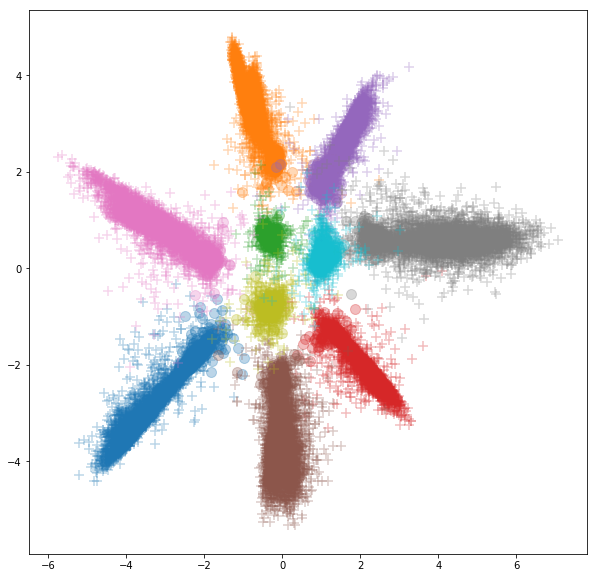

In [11]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model)
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model)


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

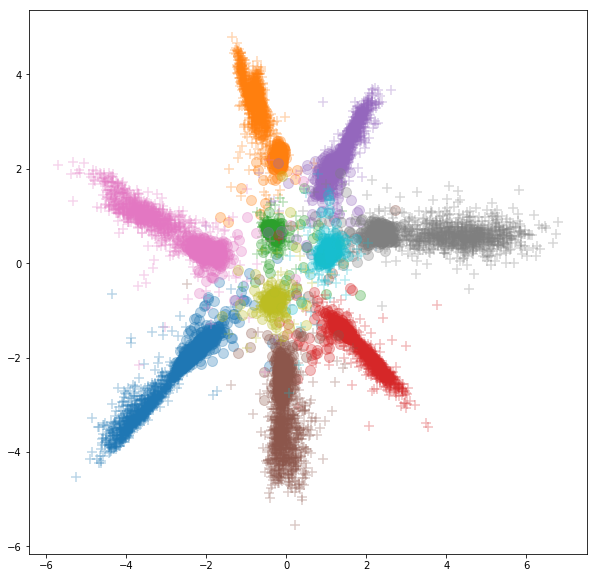

In [12]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model)
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model)


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

In [13]:
model = TripletNet(embedding_net_primary, embedding_net_helper)
torch.save(model.state_dict(), './x.pt')

In [14]:
model1 = TripletNet(embedding_net_primary, embedding_net_helper)
model.load_state_dict(torch.load('./x.pt'))

In [15]:
model1

TripletNet (
  (embedding_net_1): EmbeddingNet (
    (convnet): Sequential (
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU (1)
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU (1)
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (1600 -> 256)
      (1): PReLU (1)
      (2): Linear (256 -> 256)
      (3): PReLU (1)
      (4): Linear (256 -> 2)
    )
  )
  (embedding_net_2): EmbeddingNet (
    (convnet): Sequential (
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU (1)
      (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU (1)
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (fc): Sequential (
      (0): Linear (1600 -> 256)
      (1): PReLU (1)
      (2):